# Naiwny klasyfikator bayesowski w obliczu Tytanica
### Projekt na przedmiot: Rachunek prawdopodobieństwa i statystyka 2021
Zatonięcie parowca Tytanic jest jedną z najsłynniejszych tragedii morskich w historii człowieka, mimo uznawania za 'niezatopialny' Tytanic po zderzeniu z lodowcem zabrał ze sobą na dno 1502 z 2224 pasażerów. W poniższej pracy będziemy chcieli zbudować model służący do robienia predykcji na temat tego czy dany pasażer zginął czy przeżył.
Posłużymy sie w tym celu klasyfikatorem bayesowskim.

## Opis teoretyczny problemu

Celem projektu jest implementacja naiwnego klasyfikatora bayesowskiego, który posłuży do klasyfikacji danych pasażerów statku Tytanic do 2 klas zmiennej **Survived**:
* Przetrwał (`Survived = 1 = Yes`)
* Zginął (`Survived = 0 = No `)

Na podstawie cech:
* **passangerId** - numer identyfikacyjny pasażera
* **pclass** - której klasy biletem płynął pasażer ( 1 - pierwsza, 2 - druga, 3 - trzecia klasa)
* **name** - imię i nazwisko pasażera
* **sex** - płeć pasażera ( male - mężczyzna, female - kobieta)
* **age** - wiek pasażera w latach
* **sibsp** - ilość rodzeństwa/małżonków na pokładzie dla danego pasażera
* **parch** - ilość rodziców/dzieci na pokładzie dla danego pasażera
* **ticket** - numer biletu
* **fare** - opłata pasażera
* **cabin** - numer kabiny pasażera
* **embarked** - port w którym pasażer wszedł na pokład Tytanica ( C = Cherbourg, Q = Queenstown, S = Southampton)

W ten sposób wytrenowany klasyfikator pozwoli nam dla nowych danych pasażera określić jego los w przypadku jego wycieczki parowcem. 


Celem zaimplementowanego klasyfikaotra będzie po podaniu powyżej podanych cech $B$ obliczenie prawdopodobieństwa należenia do klasy `0` lub `1` dla atrybutu **Survived** oraz zwrócenie tej bardziej prawdopodobnej. Stąd będziemy chcieć obliczyć prawdopodobieństwo warunkowe 

$$ P(survived=0 \,\,|\,\,B) $$
oraz
$$ P(survived=1 \,\,|\,\,B) $$

W celu obliczenia powyższych prawdopodobieństw posłuzymy się _Twierdzeniem Bayesa_, które głosi, że

$$P(A\,|B) = \frac{P(B\,|A)P(A)}{P(B)}$$

Jeżeli określimy $B$ jako zbiór cech a $A$ jako zmienną **Survived** dostaniemy 
$$
P(survived | B) = \frac{P(B\,|survived)P(survived)}{P(B)}
$$

W modelu klasyfikatora będzie nas obchodziło największe prawdopodobieństwo przy predykcji, a wartość P(B) będzie stała dla danego pasażera w obu przypadkach, zatem dla zmniejszenia ilośći obliczeń będziemy obliczać tylko wartości licznika.
Naiwny klasyfikator Bayesa zakłada, że atrybuty są niezależne więc możemy powyższe równanie zapisać jako


$$

P(survived\,|B_1,\ldots,B_n) \propto P(survived)P(B_1\,|survived)P(B_2\,|survided)\ldots

$$


Zatem możemy, znając prawdopodobieństwo, że pasażer który umrze/przeżyje będzie miał dane cechy, obliczyć prawdopodobieństwo na to czy pasażer o danych cechach umrze czy przeżyje! 


***
## Obróbka i analiza danych
Przed implementacją klasyfikatora musimy jednak zadbać o jakość danych, na których będziemy trenować nasz klasyfikator. Oczywistą implikacją jest, że ze słabej jakości danych powstanie słabej jakości klasyfikator.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data = pd.read_csv('./input/titanic.csv')
data.head()

,passengerId,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S


Do danych wprowadzimy kilka korekt, które ułatwią nam pracę nad klasyfikatorem.
#### Niepotrzebne informacje

PassangerId jednoznacznie wyznacza imię i nazwisko pasażera więc możemy kolumne `Name` usunąć ze zbioru uwzględnianych danych nie tracąc żadnej informacji. Pozbycie się tych danych jest pożądane ponieważ chcemy dane zamienić na wartości liczbowe
Usuniemy również kolumnę `Ticket`, ponieważ numer identyfiakcyjny logicznie nie ma znaczenia w przypadku przeżycia danego pasażera

In [54]:
data = data.drop('name',1)
data = data.drop('ticket',1)
data.head()

,passengerId,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,1,male,0.9167,1,2,151.5500,C22 C26,S
2,2,1,0,female,2.0000,1,2,151.5500,C22 C26,S
3,3,1,0,male,30.0000,1,2,151.5500,C22 C26,S
4,4,1,0,female,25.0000,1,2,151.5500,C22 C26,S


#### Brakujące informacje
Sprawdzimy następnie jak dużo brakuje danych w dostarczonym zestawie

In [55]:
data.isnull().sum(axis=0)

passengerId       0
pclass            0
survived          0
sex               0
age             263
sibsp             0
parch             0
fare              1
cabin          1014
embarked          2
dtype: int64

Widać, że około 1/5 pasażerów nie ma podanego wieku oraz brakuje aż 5/6 kabin. Wszystkich wpisów w zbiorze danych jest tylko 1304 więc dane o kabinach odrzucimy. Jedynym sposobem na poradzenie sobie z brakującymi danymi byłoby przypisanie kabinom ich średnich cen w ich obszarze i korelacji z polem `fare` u danego pasażera. Jednak jeżeli taka korelacja by występowała to bez straty możemy zostawić samo polę fare.

In [56]:
data = data.drop('cabin',1)


Pozostaje uzupełnić pozostałe brakujące dane. Obliczymy najczęsciej występującą wartość w `embarked` oraz średnią cenę za bilet dla fare


In [57]:
from collections import Counter

embarked_counter = Counter(data['embarked'])
print("Najwięcej występującą wartością pola embarked jest: ",embarked_counter.most_common(1)[0])
fare_mean = np.mean(data['fare'])
print("Średnia opłata za bilet: ", fare_mean)

Najwięcej występującą wartością pola embarked jest:  ('S', 914)
Średnia opłata za bilet:  33.29547928134557


W takim razie pole `age` uzupełnimy posługując się rozkładem normalnym, a pola `embarked` wartością `S`

In [58]:
index = data[data.age.isna()].index
value = np.random.normal(loc=data.age.mean(), scale=data.age.std(), size=data.age.isna().sum())
data.age.fillna(pd.Series(value, index=index).abs(), inplace=True)
data.embarked.fillna('S', inplace=True)
data.fare.fillna(fare_mean, inplace=True)


Po uzupełnieniu luk w danych ostatnie co należy zrobić przed rozpoczęciem kroswalidacji to przekształcenie pól typu `string` na pola typu liczbowego

In [59]:
gender = {'male': 1, 'female': 2}
embarked_from = {'S':1, 'Q':2, 'C':3}

data.sex = [gender[item] for item in data.sex]
data.embarked = [embarked_from[item] for item in data.embarked]
data.describe()

,passengerId,pclass,survived,sex,age,sibsp,parch,fare,embarked
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,654.000000,2.294882,0.381971,1.355997,30.172478,0.498854,0.385027,33.295479,1.506494
std,378.020061,0.837836,0.486055,0.478997,14.205169,1.041658,0.865560,51.738879,0.814244
min,0.000000,1.000000,0.000000,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,327.000000,2.000000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800,1.000000
50%,654.000000,3.000000,0.000000,1.000000,29.000000,0.000000,0.000000,14.454200,1.000000
75%,981.000000,3.000000,1.000000,2.000000,39.000000,1.000000,0.000000,31.275000,2.000000
max,1308.000000,3.000000,1.000000,2.000000,80.000000,8.000000,9.000000,512.329200,3.000000


### Weryfikacja niezależnośći zmiennych losowych
Naiwność klasyfikatora bayesowskiego opiera sie na tym, że naiwnie zakłada on niezależność wszystkich zmiennych losowych. Aby uniknąć nadużycia tej naiwności zbadamy zależnosci pomiędzy każdymi dwoma parametrami. Posłużymy się do tego współczynnikiem korelacji Pearsona. Polega on na obliczeniu ilorazu kowariancji i iloczynu odchyleń standardowych zmiennych losowych. Kowariancja w tym wzorze to liczba określająca odchylenie elementów od sytuacji w której występuje zależność liniowa.

$$
r_{XY} = \frac{cov(X,Y)}{\sigma_X \sigma_Y}
$$

Dla takiej miary współczynnik korelacji będzie zawsze w przedziale $[-1, 1]$. Im bliżej jedynki tym bliżej do sytuacji proporcjonalnej, a im bliżej -1 tym bliżej do odwrotnie proporcjonalnej. Zbadamy zestaw naszych parametrów używając tego wpółczynnika

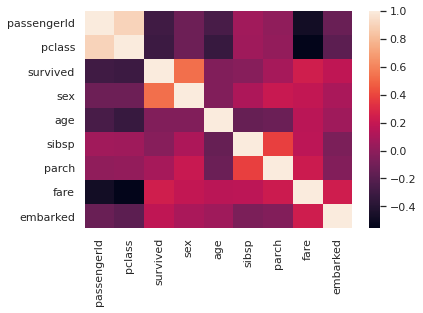

In [60]:
corr = data.corr(method='pearson')
sns.heatmap(corr)
plt.show()

Na oczy rzucają się dwie kombinacje:
* `passengerId` oraz `fare`
* `fare` oraz `pclass`

Pierwszą zignorujemy ze względu na logiczny brak powiązania między identyfikatorem pasażera a ceną biletu. Druga jednak niesie za sobą logiczną implikację: bilety klasy 1 wiążą się z wyższą ceną za przepływ od biletów innych klas! Dla dobrej praktyki w klasyfikatorze nie będziemy uwzględniać zmiennej `fare`. Wybieramy zmienną o mniejszej ilości różnych wartości aby uniknąć `overfittingu`

In [61]:
data = data.drop('fare',1)

### Stosunek klas, które będziemy klasyfikować

In [62]:
data['survived'].sum()

500

Jak widać na 1300 rekordów 500 pasażerów przeżyło. Można przewidwywać, że klasyfikator będzie chętniej klasyfikował do klasy $Survived=0$

***
# Implementacja klasyfikatora
Aby poprawnie wyewaluować prawdopodobieństwa zmiennych liczbowych założymy, że są rozkładem normalnym. Implementacja kalsyfikatora jest umieszczona w pliku `NBClassifier.py`

## Kroswalidacja
Przed zastosowaniem klasyfikatora na obrobionych wcześniej danych należy podzielić dane na zbiory treningowe i testowe. Trzeba wprowadzić taki podział, aby potem zmierzyć faktyczną skuteczność klasyfikatora na podstawie danych których wcześniej nie widział. Poniżej zaimplementujemy algorytm `k-fold` który przebiega następująco

1. Losowo przetasować zbiór danych
2. Podzielić go na **k** grup
3. Dla każdej grupy:
    * Wziąć daną grupę jako grupę testową
    * Wziąć pozostałe grupy jako grupy treningowe
    * Wytrenować model na grupach treningowych i sprawdzić wyniki dla grupy testowej
    * Zapisać wyniki i odrzucić model
4. Wyznaczyć jakość klasyfikatora używając zapisanych wyników poszczególnych grup testowych



In [63]:
from NBClassifier import NBClassifier, pre_processor, calculate_accuracy

def k_fold(k, data, threshold=0.5):
    data.sample(frac=1)
    data_slices = np.array_split(data,k)
    result = []
    for i in range(k):
        test = data_slices[i]
        train = pd.concat([data_slices[x] for x in range(k) if x != i])
        model = NBClassifier()
        train_attributes, train_target = pre_processor(train)
        train_attributes.drop('passengerId', 1)
        model.train(train_attributes, train_target)
        predicted_values, true_values = model.classify(test,threshold)
        result.append((predicted_values, true_values))
    return result

result = k_fold(5,data)


***
# Ocena modelu oraz testowanie klasyfikatora
Po wytrenowaniu naszego modelu musimy zmierzyć jego jakość. W tym celu posłużymy się nastepującymi metrykami. Każdą z poniższych metryk uzyskamy ze średniej arytmetycznej tych metryk dla poszczególnych iteracji kroswalidacji
* Trafność
* Macierz blędów
* Precyzja
* Zwrot
* Miara F1
* Krzywe ROC

## Trafność
Trafność nam mówi jaki procent predykcji naszemu klasyfikatorowi się udał. Należy zauważyć, że nie jest to najbardziej miarodajna metryka. Na przykład dla zestawu danych, w którym 90% przypadków byłoby w klasie $Survived$ nawet słaby klasyfikator przypisałby większość próbek do tej klasy.

In [64]:
accuracy = 0
for pred, true in result:
    accuracy += calculate_accuracy(pred,true)

print(accuracy/len(result))

74.48802


***
## Macierz błędów
Macierz błędów jest stosowana przy ocenie jakości klasyfikacji binarnej. Dane oznaczone etykietami: 0 lub 1 dla cechy Survived poddawane są klasyfikacji, która przypisuje im predykowaną klasę pozytywną albo predykowaną klasę negatywną. Możliwa jest sytuacja, że dana oryginalnie oznaczona jako pozytywna zostanie omyłkowo zaklasyfikowana jako negatywna. Wszystkie takie sytuacje przedstawia macierz błędów. Te sytuacje możemy podzielić na 4 kategorie:
* **TP** (ang. true positive) - ilość próbek zaklasyfikowanych poprawnie do klasy $Survived$
* **FN** (ang. false negative) - ilość próbek zaklasyfikowanych niepoprawnie do klasy $Survived$
* **TN** (ang. true negative)- ilość próbek poprawnie odrzuconych z klasy $Survived$
* **FP** (ang. false positive)- ilość próbek niepoprawnie odrzuconych z klasy $Survived$


<img src="img/Precision-vs-Recall.png"/>




<AxesSubplot:>

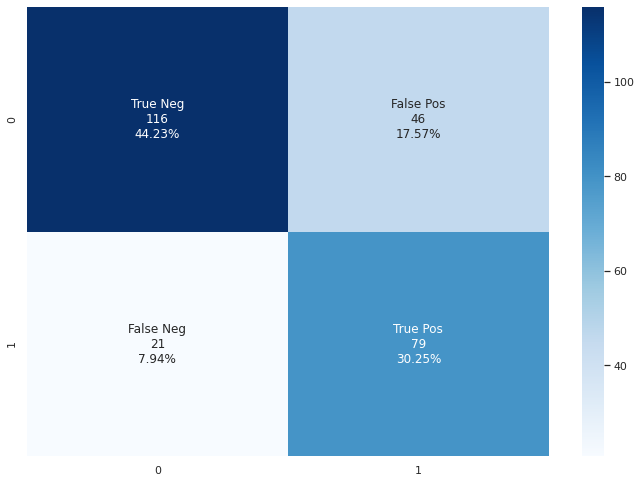

In [65]:
def calculate_conf_matrix(result):
    TP_table = []
    FN_table = []
    TN_table = []
    FP_table = []
    for pred, true in result:
        pred_vals = np.asarray(pred)
        true_vals = np.asarray(true)
        TP_table.append(np.sum(np.logical_and(pred_vals == 1, true_vals == 1)))
        TN_table.append(np.sum(np.logical_and(pred_vals == 0, true_vals == 0)))
        FP_table.append(np.sum(np.logical_and(pred_vals == 1, true_vals == 0)))
        FN_table.append(np.sum(np.logical_and(pred_vals == 0, true_vals == 1)))
    return sum(TP_table)/len(TP_table), sum(FN_table)/len(FN_table), sum(TN_table)/len(TN_table), sum(FP_table)/len(FP_table)

TP, FN, TN, FP = calculate_conf_matrix(result)

conf_matrix = np.asarray([[TN, FP], [FN, TP]])
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues')


## Precyzja
Precyzją klasyfikatora nazywamy wartość stosunku dobrze zaklasyfikowanych pasażerów do klasy $Survived$ do wszystkich pasażerów zaklasyfikowanych do klasy $Survived$
$$
 \frac{TP}{TP+FN}
$$



In [66]:
print(TP/(TP+FN))

0.792


## Czułość
Czułością (ang. _recall_) nazywamy wartość stosunku dobrze zaklasyfikowanych pasażerów do klasy $Survived$ do wszystkich pasażerów poprawnie zaklasyfikowanych
$$
\frac{TP}{TP + TN}
$$

In [67]:
print(TP/(TP+TN))

0.40615384615384614


## Specyficzność
Specyficznością(ang. _specificity_) nazywamy stosunek dobrze odrzuconych pasażerów od klasy $Survived$ do ilości wszystkich pasażerów spoza klasy $Survived$ 
$$
\frac{TN}{TN + FP}
$$

In [68]:
print(TN/(TN+FP))

0.7156983930778739


## Miara $f$
Miara $f$ (ang. _ f measure (fall-out)_ ) jest stosunkiem niepoprawnie sklasyfikowanych pasażerów do klasy $Survived$ do wszystkich niepoprawnie sklasyfikowanych pasażerów 
$$
f = \frac{FN}{FN + FP}
$$

In [69]:
print(FN/(FN+FP))

0.31137724550898205


## Krzywe ROC
Nasz klasyfikator przypisuje danego pasażera jeżeli jego wartość pola `survived_prob` będzie większa od pola `died_prob`. Można to inaczej wyrazić jako zależność

$$
\frac{\text{survived_prob}}{\text{survived_prob}+\text{died_prob}} \geq 0.5
$$


Nie mamy pewności jednak czy dla naszego klasyfikatora próg równy 0.5 jest optymalny. W celu zbadania najbardziej optymalnego progu posłużymy się metodą krzywych na wykresie zależności Czułości do Specyficzności. Przebieg doświadczenia będzie przebiegał następująco

* Ustawić próg początkowo na 0.00 i zbadać klasyfikator dla takiego progu
* Zapisać czułość oraz specyficzność modelu
* Inkrementować próg o 0.05 i powtarzać aż do osiągnięcia przez niego wartości 1

Text(0, 0.5, 'True postive rate')

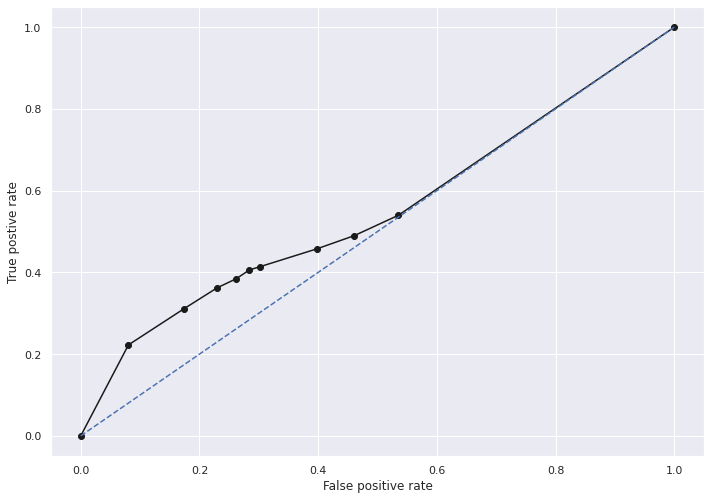

In [70]:
ROC_points_x = []
ROC_points_y = []
for i in range(11):
    result = k_fold(5, data, i*0.1)
    TP, FN, TN, FP = calculate_conf_matrix(result)
    ROC_points_x.append(TP/(TP+TN))
    ROC_points_y.append(1 - TN/(TN+FP))

plt.plot(ROC_points_y, ROC_points_x, '-ok')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False positive rate")
plt.ylabel("True postive rate")


Niebieska linia przerywana oznacza próg losowego wybierania. Dowolny punkt poniżej tej linii oznaczałby że nas klasyfikator dla danego progu wybiera gorzej niż losowo. .

## Interpretacja wyników
Zaimplementowany klasyfikator w sposób poprawny określił cechy większości próbek, lecz w celu głębszej analizy należy zwrócić uwagę na:
* Klasyfikator dobrze sobie radzi z klasyfikowaniem pasażerów, którzy umarli w wyniku zderzenia z lodowcem ale ma pewne braki przy klasyfikowaniem przetrwańców. Wynika to wprost z miary czułości która w naszym przypadku wynosi $0.40615$ oraz miary $f$ 
* Z wykresu krzywych ROC widać, że wybrany przez nas próg 0.5 jest optymalny, wszystkie powyżej na wykresie zwiększają FPR nie zwiększając bardziej TPR.
* Trafność klasyfikatora jest w porządku. Po sprawdzeniu w innych źródłach zastosowania Naive Bayes dla tego zestawu danych z biblioteki `skit learn` wynik nie odbiegał od uzyskanego naszym klasyfikatorem.
* Macierz błędów mogłaby wyglądać bardziej diagonalnie, ale w obu kategoriach przeważają dobre klasyfikacje.
